In [1]:
using CSV
using DataFrames
using PyPlot
using ScikitLearn # machine learning package
using StatsBase
using Random
using LaTeXStrings # for L"$x$" to work instead of needing to do "\$x\$"
using Printf
using PyCall

sns = pyimport("seaborn")

# (optional)change settings for all plots at once, e.g. font size
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16

# (optional) change the style. see styles here: https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
PyPlot.matplotlib.style.use("seaborn-white")   

## classifying breast tumors as malignant or benign

source: [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic))

> Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.

The mean radius and smoothness of the cell nuclei (the two features) and the outcome (M = malignant, B = benign) of the tumor are in the `breast_cancer_data.csv`.

In [2]:
df = CSV.read("breast_cancer_data.csv")
df[!, :class] = map(row -> row == "B" ? 0 : 1, df[:, :outcome])
first(df, 5)

,mean_radius,mean_smoothness,outcome,class
,Float64,Float64,String,Int64
1,13.85,1.495,B,0
2,9.668,2.275,B,0
3,9.295,2.388,B,0
4,19.69,4.585,M,1
5,9.755,1.243,B,0


## visualize the two classes distributed in feature space

Where SVM just computes a dividing plane, logistic regression calculates a probability that each point is in a partaicular class

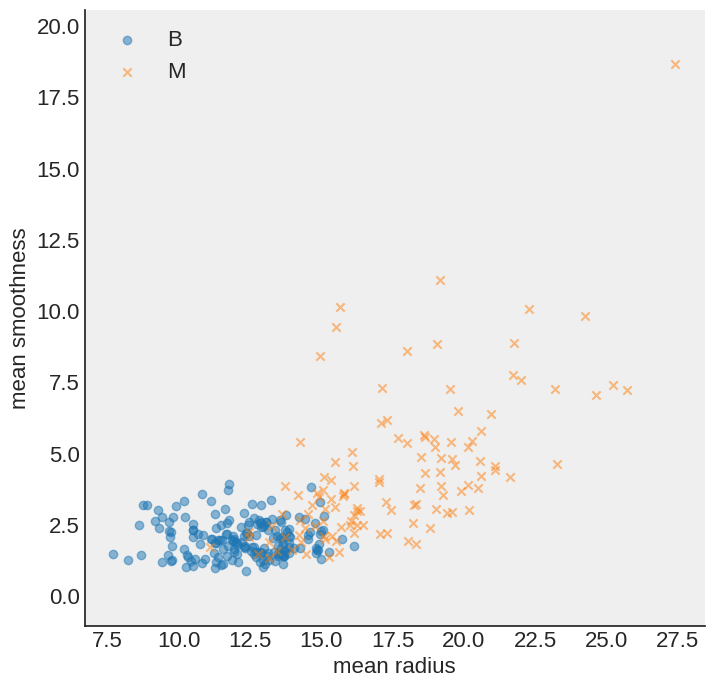

In [3]:
markers = Dict("M" => "x", "B" => "o")

fig, ax = subplots(figsize=(8, 8))
ax.set_xlabel("mean radius")
ax.set_ylabel("mean smoothness")
ax.set_facecolor("#efefef")
for df_c in groupby(df, :outcome)
    outcome = df_c[1, :outcome]
    ax.scatter(df_c[:, :mean_radius], df_c[:, :mean_smoothness], label="$outcome", 
        marker=markers[outcome], alpha=0.5)
end
legend()
axis("equal")
sns.despine()

## get data ready for classifiation in scikitlearn

scikitlearn takes as input:
* a feature matrix `X`, which must be `n_samples` by `n_features`
* a target vector `y`, which must be `n_samples` long (of course)

In [4]:
n_tumors = nrow(df)

X = zeros(n_tumors, 2)
y = zeros(n_tumors)
for (i, tumor) in enumerate(eachrow(df))
    X[i, 1] = tumor[:mean_radius]
    X[i, 2] = tumor[:mean_smoothness]
    y[i] = tumor[:class]
end
X # look at y too!

300×2 Array{Float64,2}:
 13.85   1.495
  9.668  2.275
  9.295  2.388
 19.69   4.585
  9.755  1.243
 16.11   4.533
 14.78   2.45 
 15.78   3.598
 15.71   1.972
 14.68   3.195
 13.71   3.856
 21.09   4.414
 11.31   1.831
  ⋮           
 11.08   1.719
 18.94   5.486
 15.32   4.061
 14.25   5.373
 20.6    5.772
  8.671  1.435
 11.64   2.155
 12.06   1.171
 13.88   1.709
 14.9    3.466
 19.59   2.916
 14.81   1.677

## logistic regression

let $\mathbf{x} \in \mathbb{R}^2$ be the feature vector describing a tumor. let $T$ be the random variable that denotes whether the tumor is benign (0) or malignant (1). the logistic model is a probabilistic model for the probability that a tumor is malignant given its feature vector:

\begin{equation}
    \log \frac{Pr(T=1 | \mathbf{x})}{1-Pr(T=1 | \mathbf{x})} = \beta_0 + \boldsymbol \beta^\intercal \mathbf{x}
\end{equation}
where $\beta_0$ is the intercept and $\boldsymbol \beta \in \mathbb{R}$ are the weights for the features. 

we will use scikitlearn to learn the  $\beta_0$ and $\boldsymbol \beta$ that maximize the likelihood.

In [5]:
@sk_import linear_model : LogisticRegression

PyObject <class 'sklearn.linear_model.logistic.LogisticRegression'>

$$\vec{\nabla}_{\vec{B}}\ell = \vec{0}$$

In [6]:
# default LR in sklearn has an L1 regularization, so we have to set penalty to none to fit this model
# solver minimizes grad_b l = 0
lr = LogisticRegression(penalty="none", solver="newton-cg")
lr.fit(X, y)

println("β = ", lr.coef_)
println("β₀ = ", lr.intercept_)

β = [1.168660778217552 0.9420681231447384]
β₀ = [-19.387890643955803]


prediction of the probability that a new tumor is 0 (benign) or 1 (malignant)

In [7]:
# x = [20.0 5.0]
x = [15.0 2.5]
lr.predict(x) # should be malignant for x 0
lr.predict_proba(x) # [Pr(y=0|x) PR(y-1|x)]

1×2 Array{Float64,2}:
 0.378201  0.621799

## visualize the learned model $Pr(T=1|\mathbf{x})$

In [8]:
radius = 5:0.25:30
smoothness = 0.0:0.25:20.0

lr_prediction = zeros(length(smoothness), length(radius))
for i = 1:length(radius)
    for j = 1:length(smoothness)
        # consider this feature vector
        x = [radius[i] smoothness[j]]
        # use logistic regression to predict P(y=1|x)
        lr_prediction[j, i] = lr.predict_proba(x)[2] # second elem bc want y=1
    end
end

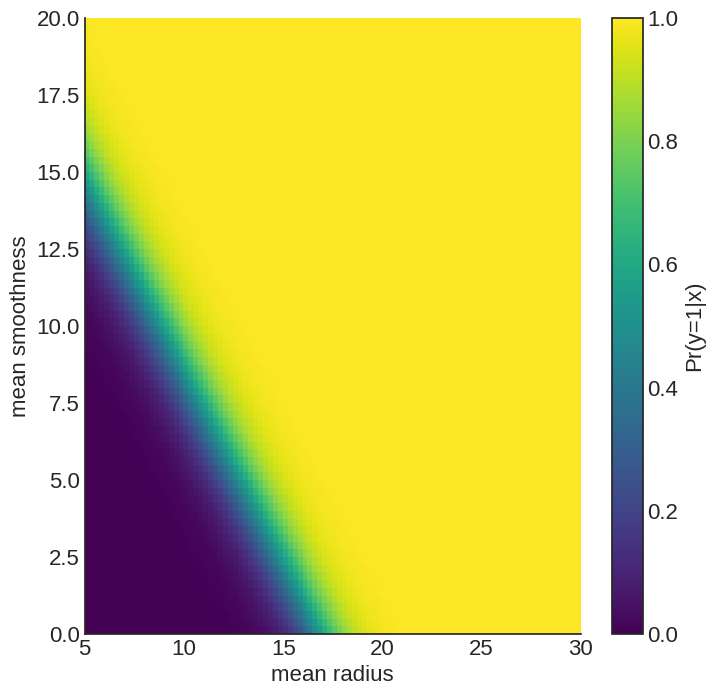

In [9]:
fig, ax = subplots(figsize=(8, 8))
ax.set_xlabel("mean radius")
ax.set_ylabel("mean smoothness")
asdf = ax.pcolor(radius, smoothness, lr_prediction, cmap="viridis", vmin=0.0, vmax=1.0)
colorbar(asdf, label="Pr(y=1|x)")
sns.despine()

TODO: add the data points in the above plot

## making decisions: the ROC curve

this depends on the cost of a false positive versus false negative. (here, "positive" is defined as testing positive for "malignant")

> "I equally value minimizing (1) false positives and (2) false negatives."

$\implies$ choose $Pr(T=1|\mathbf{x})=0.5$ as the decision boundary.

> "I'd rather predict that a benign tumor is malignant (false positive) than predict that a malignant tumor is benign (false negative)."

$\implies$ choose $Pr(T=1|\mathbf{x})=0.2$ as the decision boundary. Even if there is a relatively small chance that the tumor is malignant, we still take action and classify it as malignant...

the receiver operator characteristic (ROC) curve is a way we can evaluate a classification algorithm without imposing our values and specifying where the decision boundary should be.

In [10]:
@sk_import metrics : roc_curve
@sk_import metrics : auc

PyObject <function auc at 0x7f4f562ef378>

DIY

In [14]:
prob_pred = lr.predict_log_proba(X)[:, 2]  # PR(Y = 1 | x)
p_star = 0.2  # choose some threshold
y_pred = prob_pred .> p_star

nb_positive_examples = sum(y)
FP = sum((y_pred .== 1) & (y .== 0))  # lmao this is broken

# calculate TPR, FPR, and sweep through p*

MethodError: MethodError: no method matching &(::BitArray{1}, ::BitArray{1})
Closest candidates are:
  &(::Any, ::Any, !Matched::Any, !Matched::Any...) at operators.jl:529
  &(!Matched::PyObject, ::Any) at /home/mick/.julia/packages/PyCall/ttONZ/src/pyoperators.jl:13
  &(::Any, !Matched::PyObject) at /home/mick/.julia/packages/PyCall/ttONZ/src/pyoperators.jl:14

Using sklearn

# NOTE: Something is fucky here. P stars should be on 0, 1

In [15]:
fpr, tpr, p_stars = roc_curve(y, prob_pred)

([0.0, 0.0, 0.0, 0.005555555555555556, 0.005555555555555556, 0.011111111111111112, 0.011111111111111112, 0.027777777777777776, 0.027777777777777776, 0.03333333333333333  …  0.37222222222222223, 0.43333333333333335, 0.43333333333333335, 0.4722222222222222, 0.4722222222222222, 0.5055555555555555, 0.5055555555555555, 0.7666666666666667, 0.7666666666666667, 1.0], [0.0, 0.008333333333333333, 0.7416666666666667, 0.7416666666666667, 0.7583333333333333, 0.7583333333333333, 0.7666666666666667, 0.7666666666666667, 0.8083333333333333, 0.8083333333333333  …  0.9583333333333334, 0.9583333333333334, 0.975, 0.975, 0.9833333333333333, 0.9833333333333333, 0.9916666666666667, 0.9916666666666667, 1.0, 1.0], [0.9999999999999254, -7.460698725481331e-14, -0.2281773184684447, -0.23795226108194242, -0.25716530360843015, -0.2714716737794504, -0.2725272737389853, -0.36203897786093064, -0.4648327329708211, -0.5295512979795379  …  -2.3136622282804, -2.7295957892469147, -2.81149663007954, -2.944834369630702, -2.95

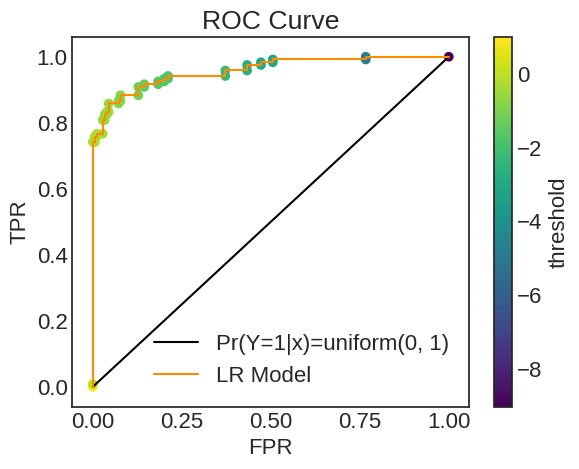

AUC = 0.9574537037037038


In [21]:
figure()
title("ROC Curve")
xlabel("FPR")
ylabel("TPR")
plot([0, 1], [0, 1], c="k", label="Pr(Y=1|x)=uniform(0, 1)")
plot(fpr, tpr, c="darkorange", label="LR Model")
scatter(fpr, tpr, c=p_stars, cmap="viridis")#, vmin=0.0, vmax=1.0)
colorbar(label="threshold")
legend()

println("AUC = ", auc(fpr, tpr))

tradeoff:
* threshold too small: classify all of the tumors as malignant, false positive rate very high
* threshold too large: classify all of the tumors as benign, false negative rate very high

somewhere in the middle (but still depending on the cost of a false positive versus false negative) is where we should operate.

the `auc`, area under the curve, has a probabilistic interpretation:
>  the area under the curve (often referred to as simply the AUC) is equal to the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one (assuming 'positive' ranks higher than 'negative') -[Wikipedia](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

**warning**: always split your data into test or train or do cross-validation to assess model performance. we trained on all data here to see the mechanics of fitting a logistic regression model to data, visualizing the model, and creating an ROC curve.